In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
if (torch.cuda.is_available()):
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import random
class FooEnv(gym.Env):
  def __init__(self,test = False):
    super().__init__()
    self.coefficients = (torch.rand([6])-0.5)*60
    self.x = torch.rand([1])*100
    self.y = torch.rand([1])*100
    self.test = test
    if self.test:
      self.coefficients = torch.ones([6])
      self.x = torch.ones([1])
      self.y = torch.ones([1])
    self.x = self.x.to(device)
    self.y = self.y.to(device)
    self.coefficients = self.coefficients.to(device)
    self.state = torch.cat([self.coefficients,self.x,self.y])
    self.length = 50
  def step(self, actionx, actiony):
    netin = self.calc()
    self.x += actionx
    self.y += actiony
    self.length-=1
    netfin = self.calc()
    info = {}
    if (netfin<netin):
      reward = 1
    else:
      reward = -5
    self.state = torch.cat([self.coefficients,self.x,self.y])
    return self.state,reward,self.length,info
  def reset(self):
    self.coefficients = (torch.rand([6])-0.5)*60
    self.x = torch.rand([1])*100
    self.y = torch.rand([1])*100
    if self.test:
      self.coefficients = torch.ones([6])
      self.x = torch.ones([1])
      self.y = torch.ones([1])
    self.x = self.x.to(device)
    self.y = self.y.to(device)
    self.coefficients = self.coefficients.to(device)
    self.state = torch.cat([self.coefficients,self.x,self.y])
    self.length = 50
  def render(self, mode='human'):
    pass
  def calc(self):
    ans = self.coefficients[0]*(self.x**2)+self.coefficients[1]*(self.y**2)+self.coefficients[2]*(self.x*self.y)+self.coefficients[3]*(self.x)+self.coefficients[4]*(self.y)+self.coefficients[5]
    return ans

environment = FooEnv()

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.m = nn.Sequential(
        nn.Linear(8,32),
        nn.Tanh(),
        nn.Linear(32,32),
        nn.Tanh(),
        nn.Linear(32,64),
        nn.Tanh(),
        nn.Linear(64,128),
        nn.Tanh(),
        nn.Linear(128,4)

    )
  def forward(self,x):
    return self.m(x)

model = Network()
model.to(device)

Network(
  (m): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
def cost(prob,rewards):
  gamma = 0.9
  reward = torch.zeros(1,requires_grad=True)
  loss = torch.zeros(1,requires_grad=True)
  reward = reward.to(device)
  loss = loss.to(device)
  for i in range(len(rewards)):
    reward = rewards[i] + gamma*reward
    loss = loss - reward*prob[i]
  return loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
testenv = FooEnv(True)

In [ ]:
episode_reward = []

In [ ]:
def reinforce(env):
  batches = 100
  eps = 50
  for i in range(batches):
    loss = torch.zeros(1,requires_grad = True)
    loss = loss.to(device)
    for j in range(eps):
      length = env.length
      state = env.state
      reward_list = []
      action_list = []
      action_prob_list = []
      while (length>0):
        params = model(state)
        mean = params[:2]
        covariance = torch.diag(params[2:])
        covariance = torch.abs(covariance)
        covariance = covariance.to(device)
        dist = torch.distributions.MultivariateNormal(mean,covariance)
        action = dist.sample()
        action_prob = dist.log_prob(action)
        state,reward,length,_ = env.step(action[0],action[1])
        reward_list.append(reward)
        action_list.insert(0,action)
        action_prob_list.insert(0,action_prob)
      loss = loss+cost(action_prob_list,reward_list)
      env.reset()
      episode_reward.append(sum(reward_list))
    print('loss : ',loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def modeltest(env):
  env.reset()
  length = env.length
  state = env.state
  while (length>0):
    with torch.no_grad():
      params = model(state)
      mean = params[:2]
      covariance = torch.tensor([[params[2],0],[0,params[3:]]])
      covariance = torch.abs(covariance)
      covariance = covariance.to(device)
      dist = torch.distributions.MultivariateNormal(mean,covariance)
      action = dist.sample()
      state,reward,length,_ = env.step(action[0],action[1])
  return env.calc().item()

In [ ]:
expected = 0
for i in range(1000):
 expected += modeltest(testenv)
expected/=1000
print(f'expected value : {expected}')

expected value : 16.864271780848505


In [ ]:
reinforce(environment)

loss :  -2096.12060546875
loss :  -22621.20703125
loss :  -35210.2734375
loss :  -42473.87109375
loss :  -45246.671875
loss :  -47237.7734375
loss :  -43663.0390625
loss :  -48470.3828125
loss :  -51612.984375
loss :  -41604.87890625
loss :  -38096.1640625
loss :  -33008.28515625
loss :  -43747.12109375
loss :  -42836.16796875
loss :  -40347.140625
loss :  -42601.0
loss :  -41781.453125
loss :  -48344.73828125
loss :  -45596.39453125
loss :  -50921.390625
loss :  -49120.75390625
loss :  -45733.4375
loss :  -51301.484375
loss :  -44055.13671875
loss :  -58804.24609375
loss :  -53730.5546875
loss :  -60194.67578125
loss :  -53367.61328125
loss :  -59272.8125
loss :  -44295.59765625
loss :  -56567.6875
loss :  -58784.4453125
loss :  -55790.88671875
loss :  -67071.28125
loss :  -55229.8828125
loss :  -59136.25390625
loss :  -51189.11328125
loss :  -55574.6328125
loss :  -56399.578125
loss :  -62266.984375
loss :  -53135.69140625
loss :  -55384.953125
loss :  -60318.01953125
loss :  -57204.

In [ ]:
expected = 0
for i in range(1000):
 expected += modeltest(testenv)
expected/=1000
print(f'expected value : {expected}')

expected value : 49.06428558665514


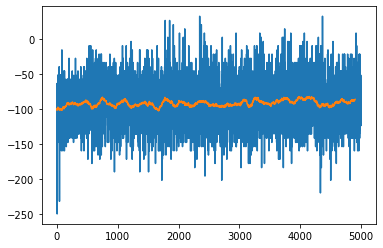

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(episode_reward)):
  episode_reward[i]  = episode_reward[i]

moving_averages = []
for i in range(100,len(episode_reward)):
  moving_averages.append(sum(episode_reward[i-100:i])/100)
plt.plot(episode_reward)
plt.plot(moving_averages)
plt.show()